In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(70000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))
print(len(word_to_index))

훈련 샘플 개수: 146182, 테스트 개수: 49157
53965


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [5]:
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]

num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


print(X_train.shape)

(146182, 41)


In [8]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 128  # 워드 벡터의 차원수 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         6907520   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 6,928,673
Trainable params: 6,928,673
Non-trainable params: 0
_________________________________________________________________


In [9]:
# validation set 50000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 약 100000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 16s 71ms/step - loss: 1.2626 - accuracy: 0.7102 - val_loss: 0.5921 - val_accuracy: 0.8456
Epoch 2/5
188/188 [==============================] - 12s 66ms/step - loss: 0.4919 - accuracy: 0.8725 - val_loss: 0.4104 - val_accuracy: 0.8510
Epoch 3/5
188/188 [==============================] - 12s 65ms/step - loss: 0.3375 - accuracy: 0.9003 - val_loss: 0.4086 - val_accuracy: 0.8499
Epoch 4/5
188/188 [==============================] - 12s 64ms/step - loss: 0.2839 - accuracy: 0.9201 - val_loss: 0.4069 - val_accuracy: 0.8473
Epoch 5/5
188/188 [==============================] - 12s 65ms/step - loss: 0.2457 - accuracy: 0.9344 - val_loss: 0.4267 - val_accuracy: 0.8459


In [11]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4392 - accuracy: 0.8412
[0.43916136026382446, 0.8412433862686157]


In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


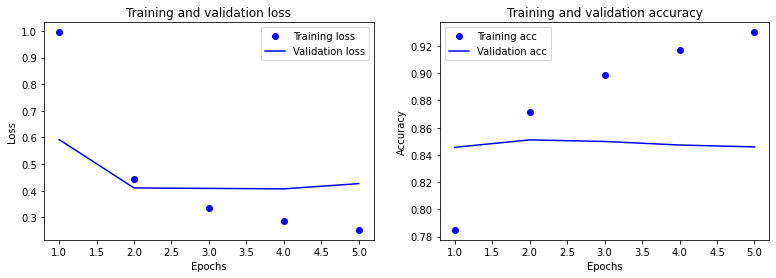

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(53965, 128)


In [15]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'//aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [16]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋']
vector

array([ 0.08177311, -0.07347293, -0.10455637,  0.05511887, -0.14860958,
       -0.09599794,  0.10613695,  0.10434977,  0.14761603,  0.05131663,
        0.08216566,  0.05713324, -0.11784288, -0.06620701,  0.05669458,
       -0.03443278, -0.03810279,  0.00588832, -0.06633087, -0.07616775,
        0.07660388, -0.03235304,  0.0746197 ,  0.00603804, -0.09854145,
       -0.16820048,  0.01704469,  0.21397044, -0.00083175, -0.04731803,
       -0.07718834, -0.12096762, -0.04685941,  0.06198945, -0.00176431,
        0.07701076,  0.02155398, -0.04574473,  0.0945992 ,  0.00709668,
        0.05270565,  0.10381973,  0.05690341, -0.0171089 , -0.07761598,
       -0.10069521, -0.00095448,  0.02858895, -0.09355573,  0.0506338 ,
        0.04848645, -0.00549424,  0.04766197, -0.07542305, -0.04148642,
        0.02219833,  0.012705  ,  0.05220634, -0.03325724, -0.11242615,
        0.07446032,  0.13365614,  0.13920332,  0.20238484,  0.09874727,
       -0.02100035, -0.08253439, -0.02235867, -0.10638317,  0.05

In [17]:
word_vectors.similar_by_word("좋")

[('짱', 0.826195478439331),
 ('맘', 0.8240185976028442),
 ('재밌', 0.7951843738555908),
 ('이럼', 0.788032591342926),
 ('간지', 0.7859430909156799),
 ('명작', 0.7724514007568359),
 ('제격', 0.7691848278045654),
 ('^^;;', 0.7647231817245483),
 ('감동', 0.7643848657608032),
 ('아싸', 0.7607522010803223)]

In [18]:
import gensim
ko_model = gensim.models.Word2Vec.load('~/aiffel/sentiment_classification/data/ko/ko.bin')
vector = ko_model['좋']
vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 1.0640332 , -2.2912955 ,  3.3337867 , -2.1199276 , -3.0332334 ,
       -0.19465393, -2.481366  , -0.10735121,  2.5207045 ,  0.8627388 ,
       -0.45329845, -2.0046058 , -0.01572813,  0.5299075 ,  0.30947903,
       -0.9715863 , -0.9571187 , -0.60102916,  0.90976727, -1.9047512 ,
       -1.2195476 , -1.1592524 ,  0.8524444 ,  1.8657554 , -0.3389445 ,
       -0.49982402,  1.1301196 , -0.5019951 ,  1.1161596 , -1.1941459 ,
        0.940446  ,  1.2571095 , -0.30472234,  1.9796319 , -1.1565856 ,
       -0.23786964, -0.6009812 ,  0.5220223 ,  0.82051736, -1.5666542 ,
       -0.02252442, -1.4792949 ,  1.3666244 ,  1.4165231 ,  1.5582582 ,
        0.8805346 ,  3.4146652 , -1.9629716 ,  0.8763886 ,  1.3238906 ,
        0.4521591 ,  0.7075807 , -2.176243  , -0.20598859, -2.23883   ,
       -1.6937513 , -2.2974951 , -0.46340045,  0.942308  ,  0.6221677 ,
        1.5814389 , -0.9991125 , -1.0794336 ,  0.9742524 , -0.8817606 ,
        1.5110779 , -2.426482  ,  0.05825558,  2.1984208 ,  0.35

In [19]:
ko_model.similar_by_word("좋")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('괜찮', 0.6849220991134644),
 ('나쁘', 0.6538200974464417),
 ('낫', 0.6441531777381897),
 ('좋아지', 0.6410495042800903),
 ('높', 0.5870170593261719),
 ('낮', 0.5831267833709717),
 ('알맞', 0.5798174142837524),
 ('많', 0.5643985867500305),
 ('귀찮', 0.5478721857070923),
 ('밝', 0.5269371867179871)]

In [20]:
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [21]:
from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(32))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           10793000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 10,823,913
Trainable params: 10,823,913
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 28s 141ms/step - loss: 1.8132 - accuracy: 0.6179 - val_loss: 0.7228 - val_accuracy: 0.8054
Epoch 2/5
188/188 [==============================] - 26s 141ms/step - loss: 0.6001 - accuracy: 0.8188 - val_loss: 0.4446 - val_accuracy: 0.8372
Epoch 3/5
188/188 [==============================] - 27s 142ms/step - loss: 0.4090 - accuracy: 0.8637 - val_loss: 0.4152 - val_accuracy: 0.8473
Epoch 4/5
188/188 [==============================] - 28s 149ms/step - loss: 0.3460 - accuracy: 0.8913 - val_loss: 0.3992 - val_accuracy: 0.8520
Epoch 5/5
188/188 [==============================] - 26s 140ms/step - loss: 0.3051 - accuracy: 0.9087 - val_loss: 0.4040 - val_accuracy: 0.8512


In [23]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4143 - accuracy: 0.8466
[0.4142515957355499, 0.8465935587882996]


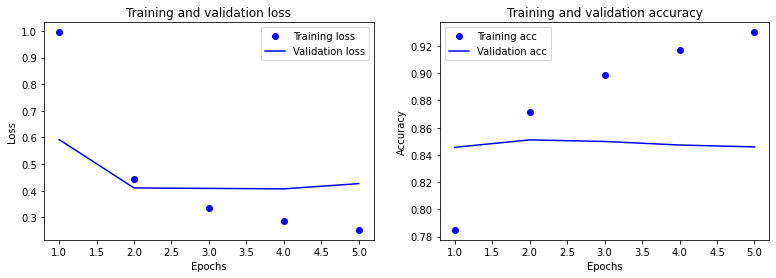

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

### CNN - GlobalMaxPooling 1D 모델

In [25]:
vocab_size = len(word_to_index)
word_vector_dim = 128   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         6907520   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          3600      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

In [26]:
X_val = X_train[:50000]   
y_val = y_train[:50000]


partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 24s 98ms/step - loss: 1.0960 - accuracy: 0.6181 - val_loss: 0.5709 - val_accuracy: 0.8452
Epoch 2/5
188/188 [==============================] - 11s 59ms/step - loss: 0.5176 - accuracy: 0.8455 - val_loss: 0.3797 - val_accuracy: 0.8534
Epoch 3/5
188/188 [==============================] - 12s 63ms/step - loss: 0.3254 - accuracy: 0.8931 - val_loss: 0.3680 - val_accuracy: 0.8520
Epoch 4/5
188/188 [==============================] - 11s 60ms/step - loss: 0.2664 - accuracy: 0.9132 - val_loss: 0.3857 - val_accuracy: 0.8509
Epoch 5/5
188/188 [==============================] - 12s 62ms/step - loss: 0.2211 - accuracy: 0.9319 - val_loss: 0.4182 - val_accuracy: 0.8472


In [28]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.4305 - accuracy: 0.8427
[0.43045565485954285, 0.842687726020813]


In [29]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


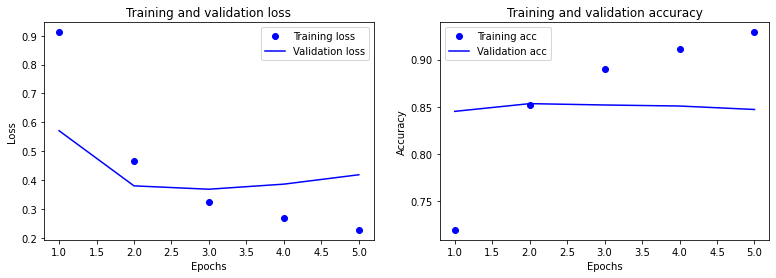

In [30]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(53965, 128)


In [32]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'//aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋']
vector

array([-1.09471129e-02,  3.96648869e-02, -6.95668999e-03,  8.64462368e-03,
       -3.22106741e-02,  6.57977611e-02,  8.87951553e-02,  8.64156485e-02,
        1.13374675e-02,  1.29219845e-01, -3.83534580e-02, -8.51909816e-03,
       -4.65246337e-03,  1.48254388e-04,  8.47899914e-02,  3.48510861e-04,
       -3.34498174e-02,  6.11049645e-02,  1.06750339e-01,  8.15265700e-02,
        9.22735489e-05,  4.27631810e-02, -7.99012482e-02, -3.99548411e-02,
        2.20169779e-02, -5.98081611e-02,  1.14137232e-01, -3.79004516e-02,
        3.89777236e-02, -6.77244738e-02, -2.81985439e-02,  6.35399371e-02,
        1.13624088e-01, -7.73325795e-04, -1.32715836e-01, -1.06529236e-01,
       -8.42811540e-03,  1.14872567e-01, -6.04388025e-03,  7.77970105e-02,
       -8.89670625e-02, -3.46640721e-02,  8.92557725e-02, -2.35564951e-02,
        2.51482110e-02, -6.38078991e-03,  3.86453159e-02,  6.60373420e-02,
        2.30441503e-02,  1.44409006e-02,  7.03738928e-02, -8.67210999e-02,
       -3.73542458e-02,  

In [34]:
word_vectors.similar_by_word("좋")

[('훌륭', 0.7002923488616943),
 ('감사', 0.6993418335914612),
 ('만족', 0.6856452226638794),
 ('낸', 0.681257963180542),
 ('10', 0.6643489599227905),
 ('전설', 0.6368192434310913),
 ('떠오를', 0.6294131875038147),
 ('찾아왔', 0.6284308433532715),
 ('유쾌', 0.6266955137252808),
 ('칰', 0.6249358654022217)]